### Distribución Espacial de las Descargas Eléctricas
***
Facultad de Ingeniería, Universidad Nacional de Asunción<br>
Laboratorio de Mecánica y Energía<br>
Est. Adriana A. Oviedo R.
***
##### Ubicación: Paraguay
*Coordenadas del área de estudio*
>-  -18,-64
>-  -18,-54
>-  -28,-64
>-  -28,-54
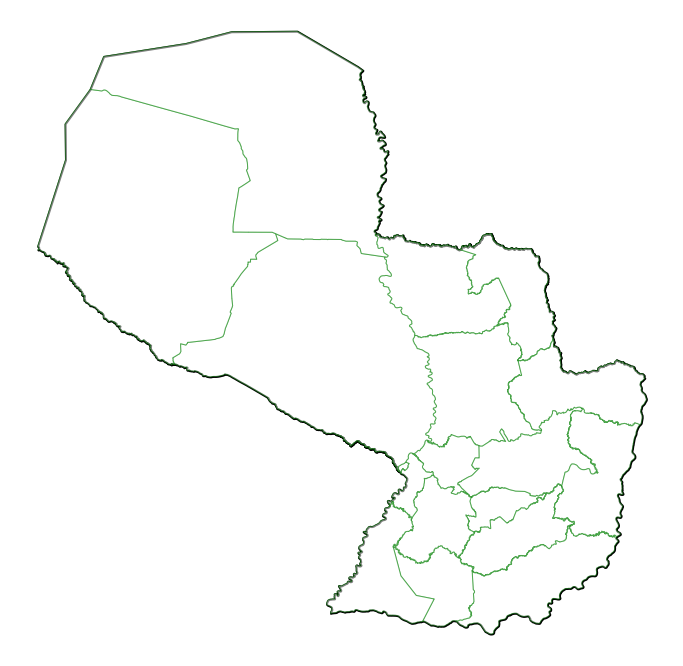
##### Periodo: 2017
##### Tipos de datos: Pulsos de descargas eléctricas
*Datos de la Dirección de Meterología e Hidrología - Paraguay*
* El timestamp de los datos indica el tiempo en el que ocurre el pulso de mayor amplitud del rayo
* Clasificación: Type
    -  "0": Cloud-to-Ground -> Descarga nube a tierra.
    -  "1": Intra-Cloud -> Descarga entre nubes; podrían indicar también otros tipos distintos de 
    las descargas CG.
    -  "9": Keep-Alive, función de los sensores para controlar su funcionamiento.
    -  "40": Provienen de otra institución, distinta a ENTLN.
* Altura: solamente indica la altura de las descargas tipo 1.
* Coordenadas: Latitud - Longitud (grados decimales)
* Polaridad: signo de la corriente máxima generada por la descarga
* Amplitud: magnitud de la corriente máxima generada por la descarga<br>
 *Datos de los mapas obtenidos del Instituto Nacional de Estadística*, descargables en:
> https://www.ine.gov.py/microdatos/cartografia-digital-2012.php
- Tipos de archivos: .shp (shapefiles)
- No posee solo contorno del Paraguay.

<div class="alert alert-block alert-info">
<b>Tip:</b> Para el uso de las librerías implementadas en este proyecto ver: https://www.earthdatascience.org/courses/intro-to-earth-data-science/</div>

In [174]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import pandas as pd
import earthpy as et
import seaborn as sns
from scipy import ndimage
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore', 'Geoseries.notna', UserWarning)

#Configuración de gráficos
sns.set(font_scale = 1.5, style = 'whitegrid')
#Configuración de directorio de trabajo
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

**Acceso a archivos .shp que contienen el contorno del país y de los departamentos en los que se divide:**
```python
mapa = gpd.read_file(mapa_ubi)


In [2]:
#Ubicaciones
pais_ubi = os.path.join('data', 'earthpy-downloads', 'rayos-paraguay',
                       'cartografia', 'contorno_Paraguay.shp')
dptos_ubi = os.path.join('data', 'earthpy-downloads', 'rayos-paraguay',
                       'cartografia', 'PAIS', 'Departamentos_Paraguay.shp')

In [3]:
#Acceso a datos de mapas
pais = gpd.read_file(pais_ubi)
dptos = gpd.read_file(dptos_ubi)
#Centroides de los polígonos que forman los departamentos, para tener una ubicación de los nombres para el gráfico
dptos_nombres = gpd.GeoDataFrame(dptos)
dptos_nombres = dptos_nombres.assign(geometry = dptos_nombres['geometry'].centroid)

C:\Users\AgOvi\AppData\Local\Temp\ipykernel_16176\1684741639.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dptos_nombres = dptos_nombres.assign(geometry = dptos_nombres['geometry'].centroid)


<div class="alert alert-block alert-info">
<b>Tip:</b> Utilizando listas, creamos listas anidadas con las ubicaciones de los archivos para más orden. Luego, utilizamos diccionarios para acceder por mes o por día a los archivos.</div>

In [4]:
#Definimos la dirección a la carpeta de los archivos de 2017
path = os.path.join('data', 'earthpy-downloads', 'rayos-paraguay',
                   'dmh', '2017\\')
list1 = [path + f for f in os.listdir(path) if f.startswith('2017_')]
list17 = []
for i in range(len(list1)):
    list17.append([list1[i]+ '\\' + f for f in os.listdir(list1[i]) if f.startswith('Paraguay_pulse')])
mes = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
      'julio', 'agosto', 'setiembre', 'octubre', 'noviembre', 'diciembre']
dia = []
for f in range(1,32):
    dia.append(f)
    
for i in range(len(list17)):
    list17[i] = dict(zip(dia,list17[i]))
    
path17 = dict(zip(mes,list17))

Para los datos de las descargas, al ser archivos .csv utilizamos la librería pandas. Luego, teniendo las columnas de Latitud y Longitud utilizamos la función points_from_xy para obtener los datos en formato GeoDataFrame

```python
descarga_fecha = pd.read_csv(ubi)
coordenadas = gpd.points_from_xy(descarga_fecha.longitude, descarga_fecha.latitude)
d_fecha = gpd.GeoDataFrame(data = descarga_fecha, geometry = coordenadas)


Obtenemos los dataframes utilizando un loop que guarda en diccionarios y los convierte a GeoDataFrames. La forma de acceder a los gdf sería la siguiente: `desc17['mes'][dia]`, donde dia es un entero y mes una cadena.

In [5]:
desc17 = {}
err17 = {}
cont_e = 0
cont_d = 0
for i in path17.keys():
    aux = []
    aux2 = []
    coord = 0
    for j in path17[i].keys():
        print('Leyendo: ', j, ' de ', i)
        try:
            aux.append(pd.read_csv(path17[i][j], parse_dates=['timestamp'],index_col=['timestamp'],
                      delimiter = ',', engine = 'python', on_bad_lines = 'warn'))
            aux[j-1].index = pd.to_datetime(aux[j-1].index, infer_datetime_format=True)
            coord = gpd.points_from_xy(aux[j-1].longitude, aux[j-1].latitude)
            aux[j-1] = gpd.GeoDataFrame(data = aux[j-1], geometry = coord, crs = pais.crs)
            aux[j-1] = gpd.clip(aux[j-1], pais)
            cont_d+=1
        except Exception as e:
            cont_e+=1
            aux.append('No data')
            aux2.append(path17[i][j])
            print(e, path17[i][j])
            continue
    desc17[i] = dict(zip(dia,aux))
    err17[i] = aux2

print(cont_e, ' errores encontrados')
print(cont_d, ' archivos leídos con éxito')

Leyendo:  1  de  enero
Leyendo:  2  de  enero
Leyendo:  3  de  enero
Leyendo:  4  de  enero
Leyendo:  5  de  enero
Leyendo:  6  de  enero
Leyendo:  7  de  enero
Leyendo:  8  de  enero
Leyendo:  9  de  enero
Leyendo:  10  de  enero
Leyendo:  11  de  enero
Leyendo:  12  de  enero
Leyendo:  13  de  enero
Leyendo:  14  de  enero
Leyendo:  15  de  enero
Leyendo:  16  de  enero
Leyendo:  17  de  enero
Leyendo:  18  de  enero
Leyendo:  19  de  enero
Leyendo:  20  de  enero
Leyendo:  21  de  enero
Leyendo:  22  de  enero
Leyendo:  23  de  enero
Leyendo:  24  de  enero
Leyendo:  25  de  enero
Leyendo:  26  de  enero
Leyendo:  27  de  enero
Leyendo:  28  de  enero
Leyendo:  29  de  enero
Leyendo:  30  de  enero
Leyendo:  31  de  enero
Leyendo:  1  de  febrero
Leyendo:  2  de  febrero
Leyendo:  3  de  febrero
Leyendo:  4  de  febrero


Skipping line 8065: Expected 10 fields in line 8065, saw 13


Leyendo:  5  de  febrero
Leyendo:  6  de  febrero
Leyendo:  7  de  febrero
Leyendo:  8  de  febrero
Leyendo:  9  de  febrero
Leyendo:  10  de  febrero
Leyendo:  11  de  febrero
Leyendo:  12  de  febrero
Leyendo:  13  de  febrero
Leyendo:  14  de  febrero
Leyendo:  15  de  febrero
Leyendo:  16  de  febrero
Leyendo:  17  de  febrero
Leyendo:  18  de  febrero
Leyendo:  19  de  febrero
Leyendo:  20  de  febrero
Leyendo:  21  de  febrero
Leyendo:  22  de  febrero
Leyendo:  23  de  febrero
Leyendo:  24  de  febrero
Leyendo:  25  de  febrero
Leyendo:  26  de  febrero
Leyendo:  27  de  febrero
Leyendo:  28  de  febrero
Leyendo:  1  de  marzo
Leyendo:  2  de  marzo
Leyendo:  3  de  marzo
Leyendo:  4  de  marzo
Leyendo:  5  de  marzo
Leyendo:  6  de  marzo
Leyendo:  7  de  marzo
Leyendo:  8  de  marzo
Leyendo:  9  de  marzo
Leyendo:  10  de  marzo
Leyendo:  11  de  marzo
Leyendo:  12  de  marzo
Leyendo:  13  de  marzo
Leyendo:  14  de  marzo
Leyendo:  15  de  marzo
Leyendo:  16  de  marzo
Leyend

No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170801.csv
Leyendo:  2  de  agosto
Leyendo:  3  de  agosto
Leyendo:  4  de  agosto
No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170804.csv
Leyendo:  5  de  agosto
No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170805.csv
Leyendo:  6  de  agosto
No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170806.csv
Leyendo:  7  de  agosto
No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170807.csv
Leyendo:  8  de  agosto
Leyendo:  9  de  agosto
No columns to parse from file data\earthpy-downloads\rayos-paraguay\dmh\2017\2017_08\Paraguay_pulse20170809.csv
Leyendo:  10  de  agosto
Leyendo:  11  de  agosto
Leyendo:  12  de  agosto
Leyendo:  13  de  agosto
Leyendo:  14  de  agosto
Leyendo:  1

err17 es un diccionario que guarda las ubicaciones de los archivos que tengan un error, en este caso el más común son los archivos vacíos. Otro error serían lineas dentro de los archivos que tienen más datos que las columnas leídas, este error se maneja directamente con el
`pd.read_csv(path, on_bad_lines = 'warn')`

In [6]:
dia_mes = dict(zip(mes,[31, 28, 31, 30,31,30,31,31,30,31,30,31]))
mes_code = dict(zip(mes,['01','02','03','04','05','06','07','08', '09','10','11','12']))

def que_fecha():
    x = True
    while x:
        month = input('Ingrese el mes: ')
        if month in mes:
            x = False
        else:
            x = True
            print('Entrada no válida ', mes)
    y = True
    dia_mes = dict(zip(mes,[31, 28, 31, 30,31,30,31,31,30,31,30,31]))
    while y:
        day = int(input('Ingrese el dia: '))
        if (day <= dia_mes[month]) and day!=0:
            y = False
        else:
            y = True
            print('Entrada no valida para el mes de ', month)
    return [month, day]

def save_plot_map(month, day):
    '''
    Genera y guarda el gráfico del mapa con los respectivos rayos de la fecha
    
    '''
    x = month
    y = day
    mes_code = dict(zip(mes,['01','02','03','04','05','06','07','08', '09','10','11','12']))
    try:
        f, ax = plt.subplots(figsize=(20,20))
        pais.plot(color = 'white', edgecolor = 'black', ax=ax, legend = True)
        dptos.plot(ax=ax, alpha=.5, edgecolor = 'k', color='white')
        desc17[x][y].plot(ax=ax, column = 'type', markersize = 2, cmap = 'jet', categorical=True, legend=True)
        dptos_nombres.plot(markersize=10, color='white', ax=ax)
        dptos_nombres.apply(lambda x: ax.annotate(text=x['DPTO_DESC'], xy = x.geometry.coords[0],
                                             xytext=(-25,0), textcoords = 'offset points'), axis = 1)
        f.suptitle('Descargas Eléctricas en Paraguay\n'+str(y)+'/'+ mes_code[month] +'/2017', fontsize=24)
        plt.savefig(os.path.join('data', 'earthpy-downloads','rayos-paraguay','dist espacial','2017',
                                 mes_code[month], str(y)+'_'+mes_code[month]+'_2017.png'), facecolor = 'white',
                    bbox_inches = 'tight', dpi = 150)
        plt.close(f)
        plt.show()
    except Exception as e:
        print('Esta fecha no tiene datos\n',e)
        
def plot_map(month, day):
    x = month
    y = day
    mes_code = dict(zip(mes,['01','02','03','04','05','06','07','08', '09','10','11','12']))
    try:
        f, ax = plt.subplots(figsize=(20,20))
        pais.plot(color = 'white', edgecolor = 'black', ax=ax, legend = True)
        dptos.plot(ax=ax, alpha=.5, edgecolor = 'k', color='white')
        desc17[x][y].plot(ax=ax, column = 'type', markersize = 2, cmap = 'jet', categorical=True, legend=True)
        dptos_nombres.plot(markersize=10, color='white', ax=ax)
        dptos_nombres.apply(lambda x: ax.annotate(text=x['DPTO_DESC'], xy = x.geometry.coords[0],
                                             xytext=(-25,0), textcoords = 'offset points'), axis = 1)
        f.suptitle('Descargas Eléctricas en Paraguay\n'+str(y)+'/'+ mes_code[month] +'/2017', fontsize=24)
        plt.show()
    except Exception as e:
        print('Esta fecha no tiene datos\n',e)

In [ ]:
def txt_error():
    for key in err17.keys():
        path = os.path.join('data','earthpy-downloads','rayos-paraguay','dmh','2017')
        path = path + '\\2017_' + mes_code[key] + '\\error_' + mes_code[key] + '.txt'
        file = open(path, 'w')
        file.write('---------- Archivos sin datos - '+key+' ----------\n')
        for i in err17[key]:
            file.write(i +'\n')
        file.close()
        print(path)

In [155]:
desc17['enero'][28]

,type,latitude,longitude,peakcurrent,icheight,numbersensors,majoraxis,minoraxis,bearing,geometry
timestamp,,,,,,,,,,


#### Distribución Temporal de las descargas eléctricas del año 2017
Distribución por estación, por mes, por semana y por día de las descargas eléctricas en el Paraguay.
Datos recortados respecto a los límites del contorno del país.

In [157]:
df17 = gpd.GeoDataFrame()
for i in mes:
    for j in range(1, dia_mes[i]+1):
        try:
            df17 = pd.concat([df17,desc17[i][j]],axis=0)
            print('-')
        except:
            df17 = pd.concat([df17,desc17['enero'][28]],axis=0)
            print('err')

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
err
err
-
-
-
err
-
-
-
-
err
err
-
-
-
err
err
err
-
-
-
-
-
-
err
err
-
-
-
-
-
-
-
-
-
err
-
-
-
-
err
-
-
-
-
-
-
-
-
-
err
err
err
-
-
-
-
-
-
err
-
-
-
-
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
-
err
err
err
err
err
-
-
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
-
-
err
err
err
err
-
err
-
-
-
-
-
-
-
-
-
-
-
err
err
-
err
err
-
-
-
err
err
err
err
err
err
-
-
err
err
-
-
-
-
-
-
-
-
-
err
err
err
err
-
-
-
-
-
-
-
-
-
-
-
-
-
err
err
-
-
-
-
-
-
-
-
err
err
err
-
-
-
-
-
-
err
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
err
err
err
err
-
-
-
-
-
-
-
-
err
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
err
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [330]:
df17.sort_index(inplace=True)
df17_res = df17.resample('M').peakcurrent.count()

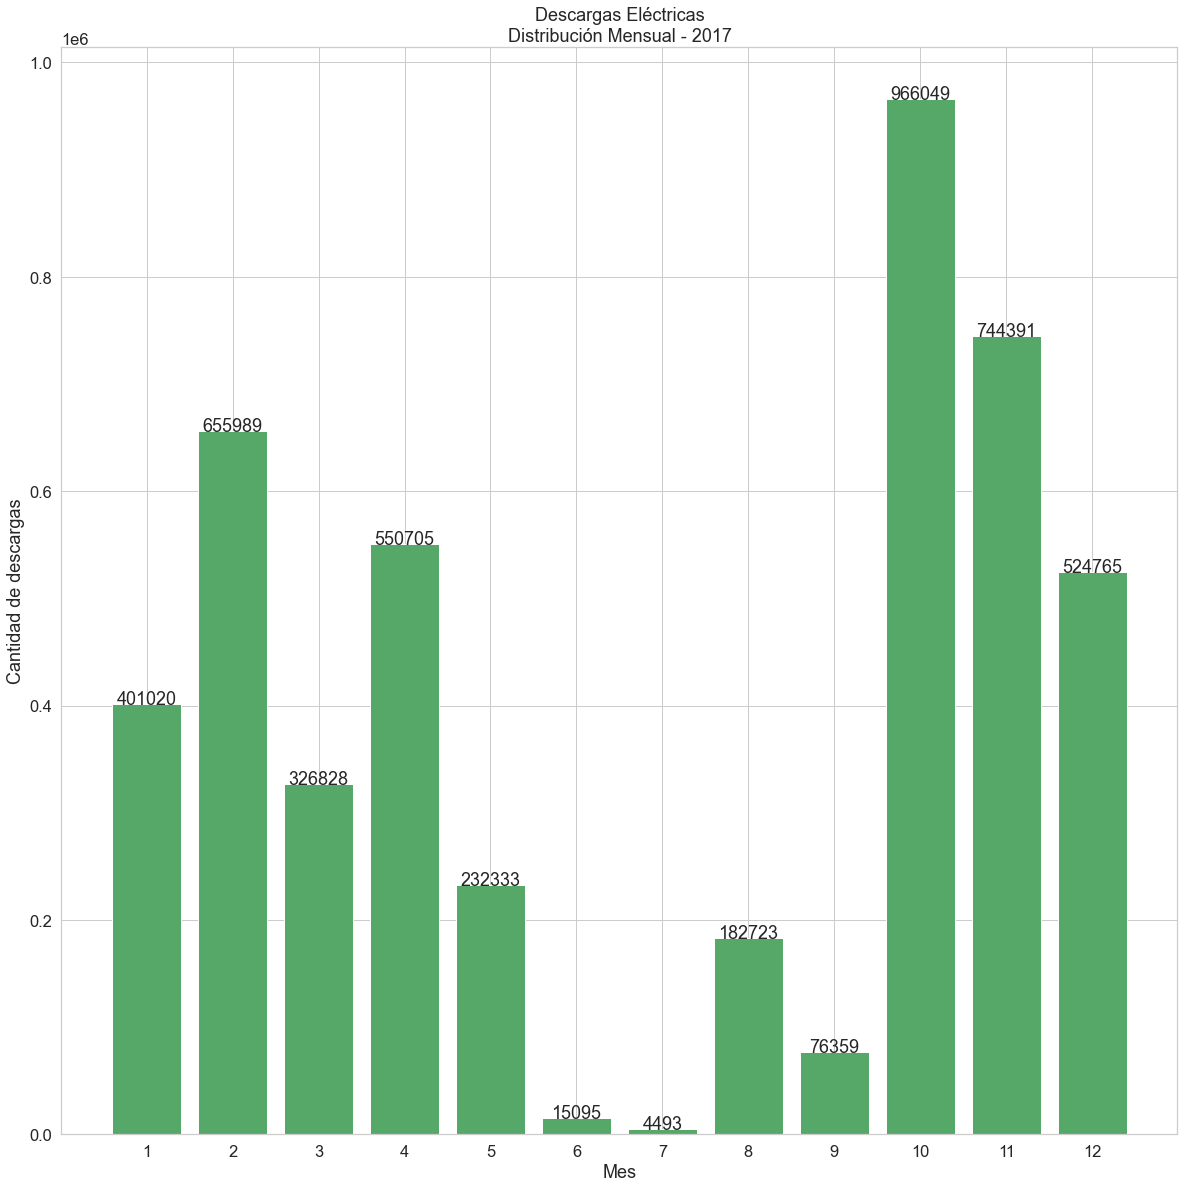

In [385]:
f, ax = plt.subplots(figsize = (20,20))
ax.bar(df17_res.index.month.values, df17_res, color = 'g')
ax.set(title = 'Descargas Eléctricas\nDistribución Mensual - 2017', xlabel ='Mes', ylabel = 'Cantidad de descargas')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=13))
for index, value in enumerate(df17_res):
    plt.text(index+1, value,
             str(value), horizontalalignment='center')
plt.show()

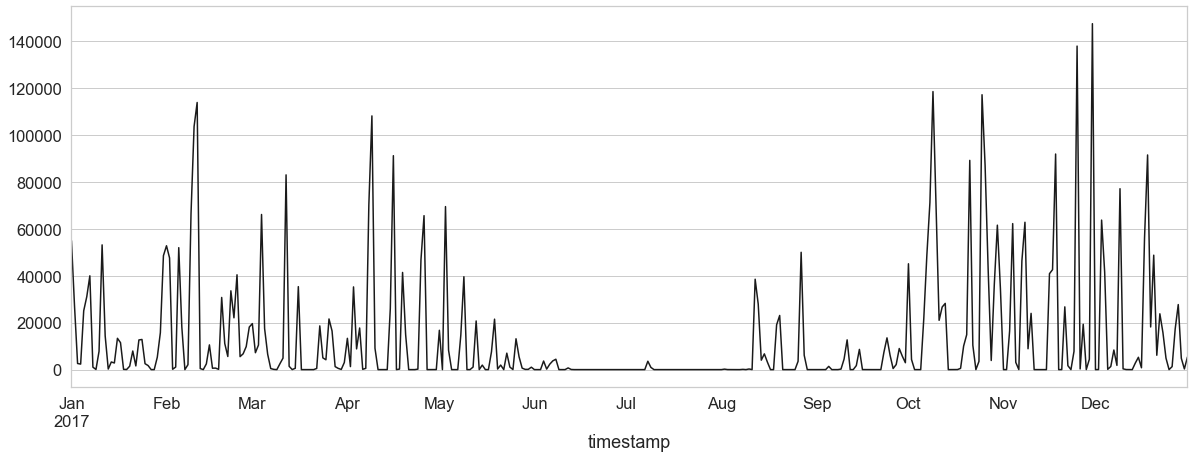

In [400]:
df17_res2 = df17.resample('D').peakcurrent.count()
f, ax = plt.subplots(figsize=(20,7))
df17_res2.plot(ax =ax,color = 'k')
ax.xaxis.grid()
plt.show()